In [1]:
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '..//../'

In [2]:
# load functions needed
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_terraclimate_all(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Returns terraclimate data.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').compute()
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        data = data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return data

def get_terraclimate_months(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month."""
    ds = get_terraclimate_all(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    ds_month = [ds.groupby('time.month').max(dim='time'), 
                ds.groupby('time.month').min(dim='time'),
                ds.groupby('time.month').mean(dim='time'),
                ds.groupby('time.month').std(dim='time')]    
    return ds_month

def get_terraclimate(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month and make each month/asset a new variable."""
    ds_list = get_terraclimate_months(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    # hard code in labels for quantities. order is abritrary from get_terraclimate_months
    quantities = ['max','min','mean','std']

        # sets_list is a list of lists of datasets, each dataset has data for each metric/quantity pair
        # I need to unpack it twice. 
    sets_list = []
    for count, ds in enumerate(ds_list):
        sets = [
            ds.sel(month=month
                ).rename(
            {var: ' '.join((str(month), var, quantities[count])) for var in list(ds.keys())}
        ).drop_vars('month')
        for month in ds.month.values
        ]
        sets_list.append(sets)
    ds = xr.merge(
            # unpack each list in sets_list and merge into a larger dataset
        [xr.merge(sets_list[i]) for i in range(len(sets_list))]
            # merge these larger datasets into a dataset and
            # convert it into a data array, and rename the variable to band
        ).to_array().rename(variable='band')   
    return ds

def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
     # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [3]:
with open('rob_and_lealia_model.pkl','rb') as inpickle:
    full_model = pickle.load(inpickle)
time_slice = ('2015-01-01','2019-12-31')
assets=['tmax', 'tmin', 'ppt', 'soil']

In [4]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')
# Read in test regions
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Note: with the TerraClimate parameters we have set, some areas of each region contain nulls. If this is the case, the prediction will return a null, which evaluates to false when we create the binary mask.

In [ ]:
# Create time slices for the last 60 years, centerd on 1967 to 2017 in 5 year chunks
## eg 2015 to 2019 (centered on 2017), 1965 to 1969 (centered on 1967)


In [22]:
centered_years = np.arange(1967,2022,5)
timeslice_list= []
for year in list(centered_years):
    timeslice_list.append((str(year-2)+'-01-01',str(year+2)+'-12-31'))

In [23]:
timeslice_list

[('1965-01-01', '1969-12-31'),
 ('1970-01-01', '1974-12-31'),
 ('1975-01-01', '1979-12-31'),
 ('1980-01-01', '1984-12-31'),
 ('1985-01-01', '1989-12-31'),
 ('1990-01-01', '1994-12-31'),
 ('1995-01-01', '1999-12-31'),
 ('2000-01-01', '2004-12-31'),
 ('2005-01-01', '2009-12-31'),
 ('2010-01-01', '2014-12-31'),
 ('2015-01-01', '2019-12-31')]

In [85]:
years_results_list = []
for count, time_slice in enumerate(timeslice_list):
    # Obtain predictor data for each region and get predictor image
    print("predicting with data from "+str(centered_years[count]))
    print(time_slice)
    for region in test_regions:
        region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
        region['predictors'] = get_terraclimate(region['bbox'], time_slice=time_slice, assets=assets)
        region['probability'] = predict_frogs(region['predictors'], full_model)
        region['result'] = region['probability'] > 0.5
    
    predictions = pd.DataFrame()
    for region in test_regions:
        preds = (
            region['probability'].rename('probability')
            .sel(
                x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
                y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
                method="nearest"
            )
            .to_dataframe()
            .reset_index()
            .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
        )
        preds['occurrenceStatus'] = preds['probability'] > 0.5
        predictions = predictions.append(preds)

    submission = (    
        predictions.merge(
            test_file, 
            on=['decimalLongitude', 'decimalLatitude'], 
            how='left', suffixes = ('', '_'))
        #[test_file.columns]
        #.fillna(0)
        #.astype({col:'int' for col in test_file.columns[3::]})
    )
    years_results_list.append([centered_years[count],submission])


predicting with data from 1967
('1965-01-01', '1969-12-31')
Loading data
Loading data
Loading data
Loading data
Loading data
predicting with data from 1972
('1970-01-01', '1974-12-31')
Loading data
Loading data
Loading data
Loading data
Loading data
predicting with data from 1977
('1975-01-01', '1979-12-31')
Loading data
Loading data
Loading data
Loading data
Loading data
predicting with data from 1982
('1980-01-01', '1984-12-31')
Loading data
Loading data
Loading data
Loading data
Loading data
predicting with data from 1987
('1985-01-01', '1989-12-31')
Loading data
Loading data
Loading data
Loading data
Loading data
predicting with data from 1992
('1990-01-01', '1994-12-31')
Loading data
Loading data
Loading data
Loading data
Loading data
predicting with data from 1997
('1995-01-01', '1999-12-31')
Loading data
Loading data
Loading data
Loading data
Loading data
predicting with data from 2002
('2000-01-01', '2004-12-31')
Loading data
Loading data
Loading data
Loading data
Loading data


In [135]:
test_regions[0].keys()

dict_keys(['title', 'bbox', 'coords', 'predictors', 'result', 'probability'])

In [136]:
test_regions[0]['bbox']

(144.8, -38.5, 145.8, -37.5)

In [87]:
years_results_list

[[1967,
          id  decimalLatitude  decimalLongitude  probability  occurrenceStatus  \
  0        0       -37.937500        145.187500     0.172069             False   
  1        1       -37.770833        144.979167     0.157540             False   
  2        2       -37.979167        145.354167     0.184099             False   
  3        3       -37.604167        145.020833     0.127028             False   
  4        4       -38.479167        145.645833     0.167731             False   
  ...    ...              ...               ...          ...               ...   
  4046  4046       -31.895833        116.145833     0.121096             False   
  4047  4047       -32.395833        115.770833     0.110106             False   
  4048  4048       -32.145833        115.854167     0.119000             False   
  4049  4049       -31.812500        116.229167     0.120663             False   
  4050  4050       -31.562500        116.062500     0.116097             False   
  
     

In [88]:
import pickle
with open('20220611_60years_results_list_w_probabilities.pkl','wb') as outpickle:
    pickle.dump(years_results_list, outpickle, pickle.HIGHEST_PROTOCOL)

In [89]:
import holoviews as hv
hv.extension('bokeh')
import pandas as pd

ModuleNotFoundError: No module named 'holoviews'

(array([1828.,  261.,   31.,  163., 1130.,  336.,  152.,    3.,   19.,
         104.]),
 array([0.09754141, 0.16502255, 0.23250369, 0.29998483, 0.36746598,
        0.43494712, 0.50242826, 0.5699094 , 0.63739054, 0.70487168,
        0.77235282]),
 <BarContainer object of 10 artists>)

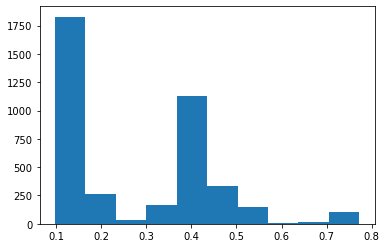

In [93]:
preds_list = []
for i in range(len(years_results_list)):
    preds = years_results_list[i][1]
    preds_list.append(preds)
predictions_all = pd.concat(preds_list)
plt.hist(
    years_results_list[0][1].probability)

In [110]:
def plot_hist_in_time(data, title, crs = {'init':'epsg:4326'}):
    """Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(3,4, figsize = (25,6))
    for index in range(len(data)):
        year_data = data[index]
        subplot_index = int(index/3),index%4
        ax[subplot_index].hist(year_data.probability)

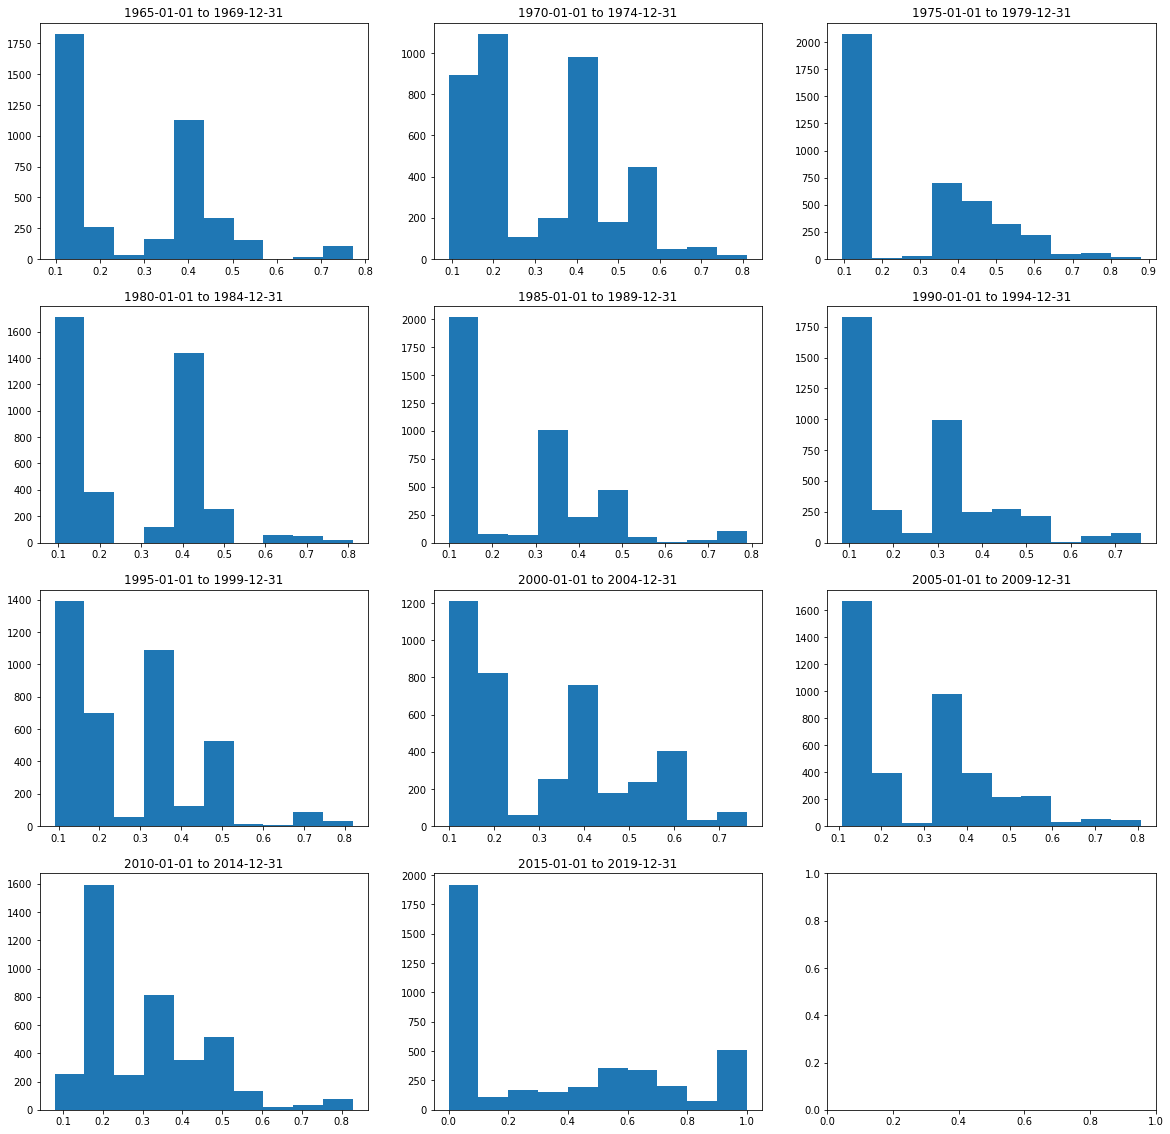

In [128]:

fig, ax = plt.subplots(4,3, figsize = (20,20))
for index in range(len(years_results_list)):
    year_data = years_results_list[index][1]
    subplot_index = int(index/3),index%3
    ax[subplot_index].hist(year_data.probability)
    ax[subplot_index].title.set_text(#str(years_results_list[index]))
        str(timeslice_list[index][0]) +' to '+str(timeslice_list[index][1]))

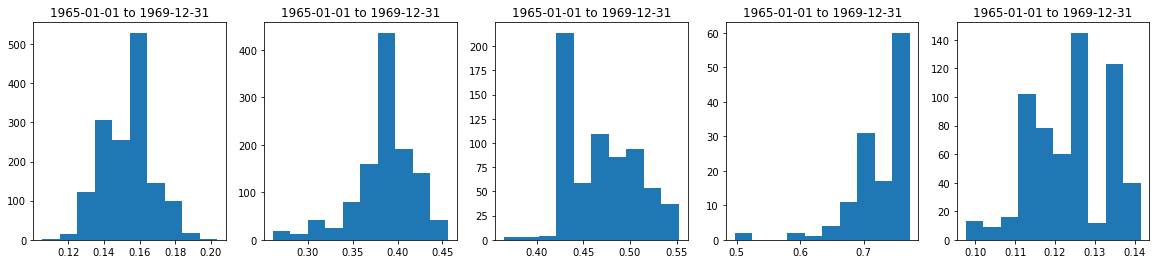

In [150]:

fig, ax = plt.subplots(1,5, figsize = (20,4))
for index in range(len(years_results_list)):
    year_data = years_results_list[index][1]
    for subplot_index in range(0,5):
    #subplot_index = int(index/3),index%3
        temp = year_data[(year_data.decimalLatitude <= test_regions[subplot_index]['bbox'][3])
                         & (year_data.decimalLatitude >= test_regions[subplot_index]['bbox'][1])] 
        ax[subplot_index].hist(temp.probability)
        ax[subplot_index].title.set_text(#str(years_results_list[index]))
            str(timeslice_list[index][0]) +' to '+str(timeslice_list[index][1]))
    plt.show()

In [180]:
list(np.arange(0,1+size,size))

[0.0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0]

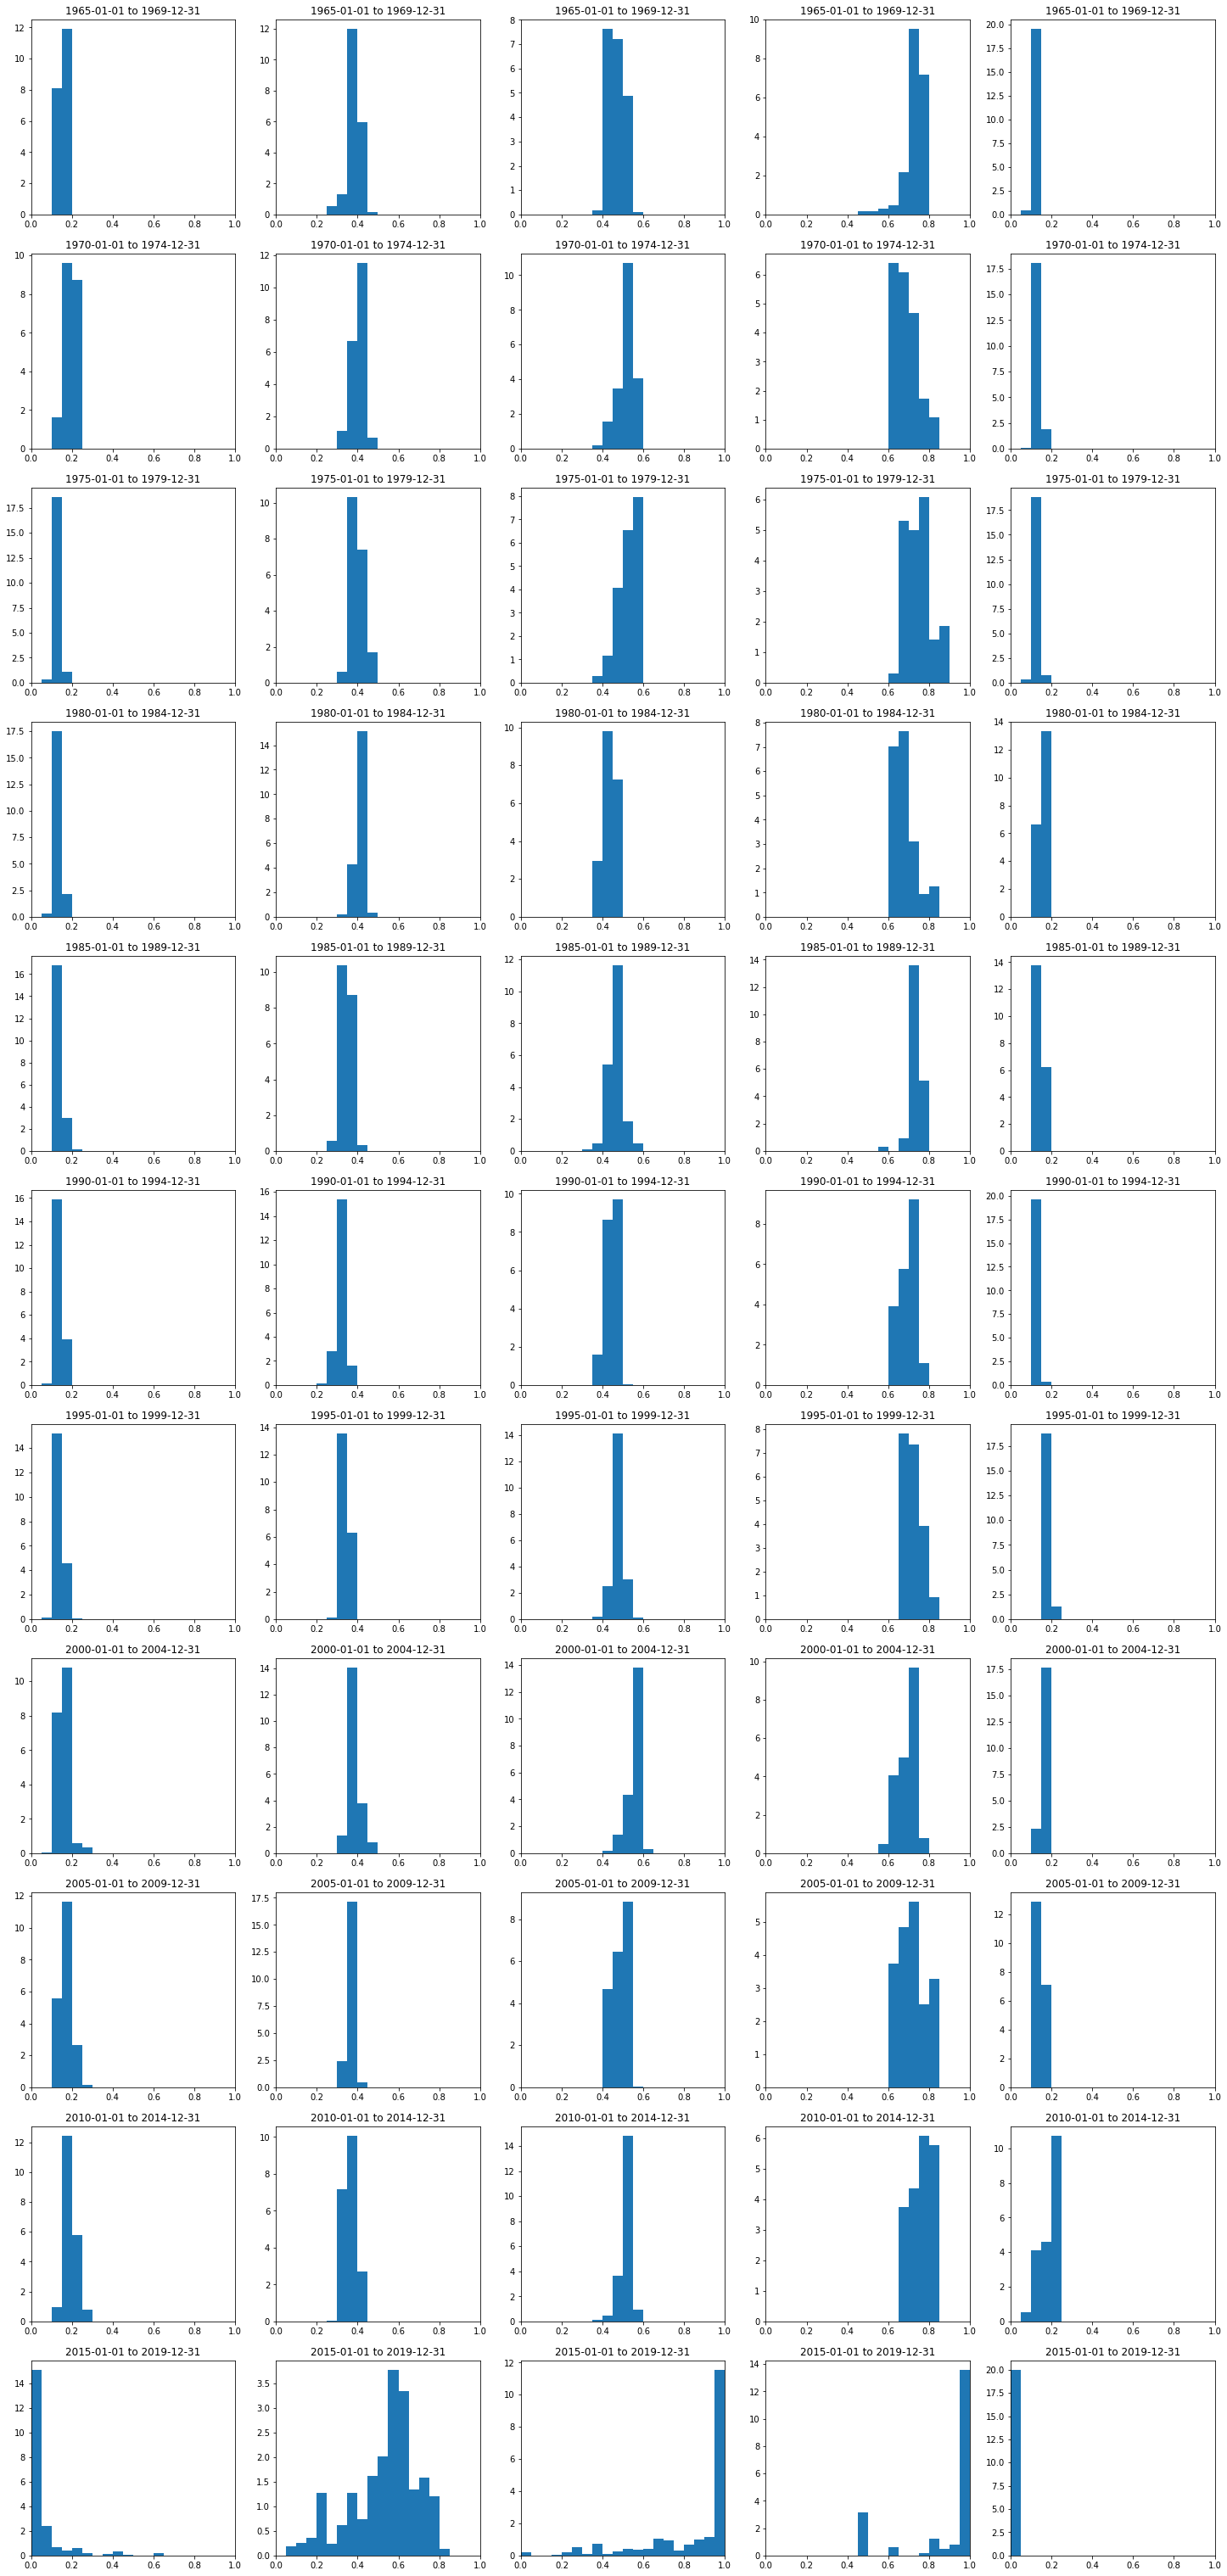

In [181]:
size = 0.05
fig, ax = plt.subplots(11,5, figsize = (25,55))
for index in range(len(years_results_list)):
    year_data = years_results_list[index][1]
    for subplot_index in range(0,5):
        subplot_ID = (index, subplot_index)
        temp = year_data[(year_data.decimalLatitude <= test_regions[subplot_index]['bbox'][3])
                         & (year_data.decimalLatitude >= test_regions[subplot_index]['bbox'][1])] 
        ax[subplot_ID].hist(temp.probability, 
                            #bins=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
                            bins=list(np.arange(0,1+size,size)),
                            density=True,)
        ax[subplot_ID].set_xlim(0,1)
        ax[subplot_ID].title.set_text(#str(years_results_list[index]))
            str(timeslice_list[index][0]) +' to '+str(timeslice_list[index][1]))
plt.show()

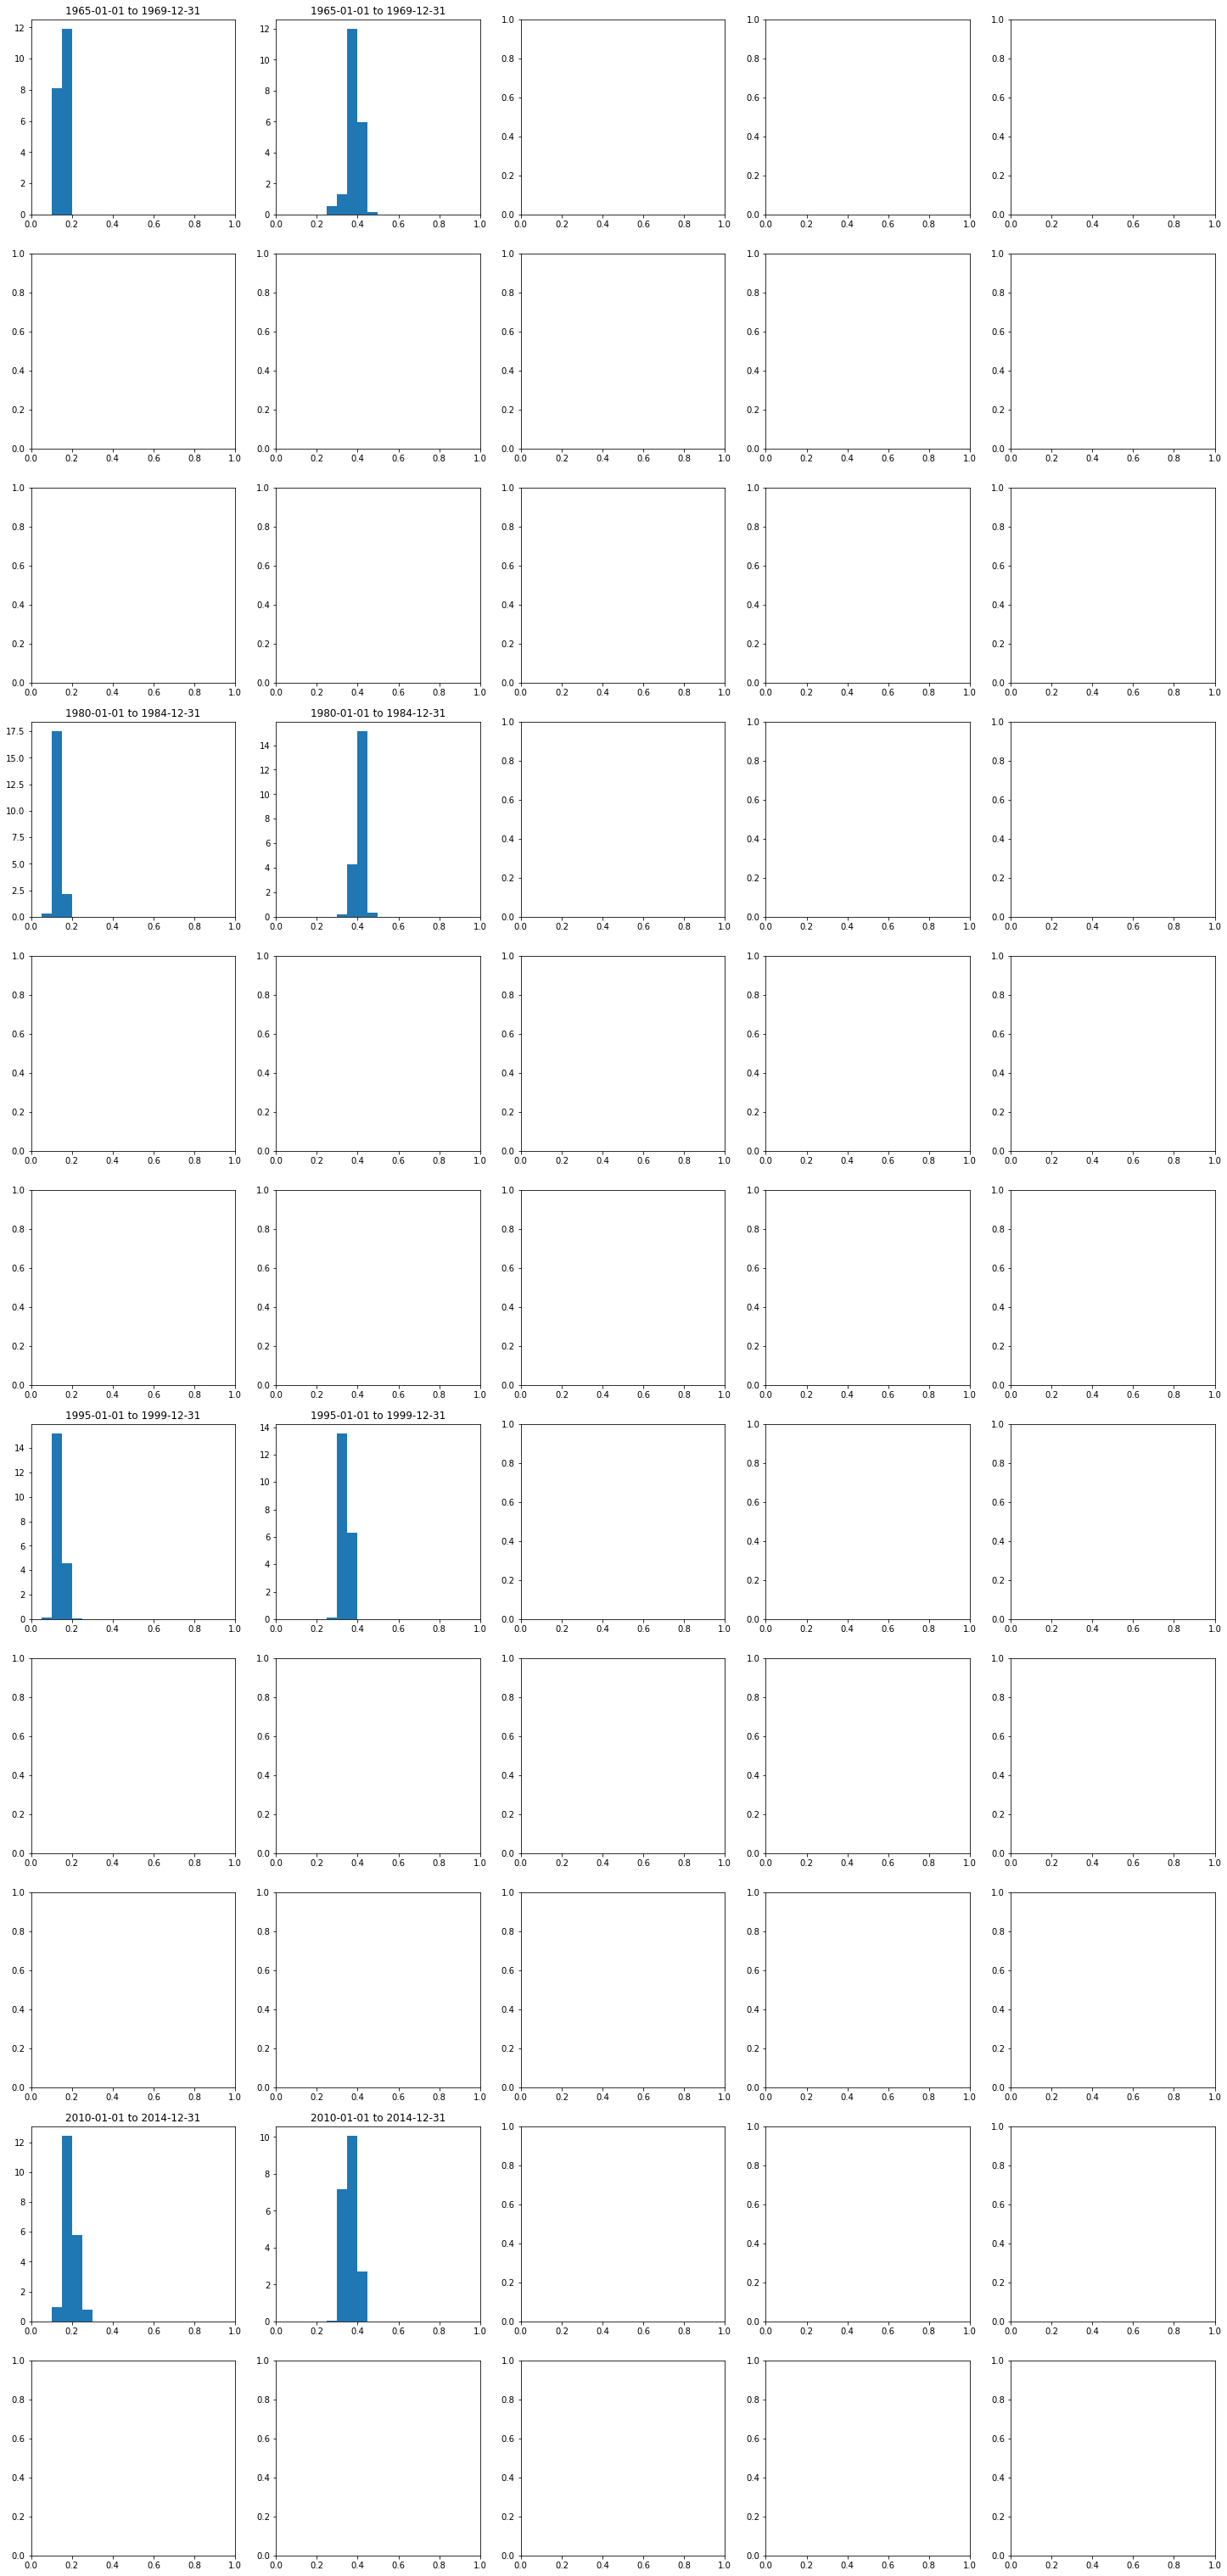

In [183]:
size = 0.05
fig, ax = plt.subplots(11,5, figsize = (25,55))
for index in range(len(years_results_list))[0::3]:
    year_data = years_results_list[index][1]
    for subplot_index in range(0,2):
        subplot_ID = (index, subplot_index)
        temp = year_data[(year_data.decimalLatitude <= test_regions[subplot_index]['bbox'][3])
                         & (year_data.decimalLatitude >= test_regions[subplot_index]['bbox'][1])] 
        ax[subplot_ID].hist(temp.probability, 
                            #bins=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
                            bins=list(np.arange(0,1+size,size)),
                            density=True,)
        ax[subplot_ID].set_xlim(0,1)
        ax[subplot_ID].title.set_text(#str(years_results_list[index]))
            str(timeslice_list[index][0]) +' to '+str(timeslice_list[index][1]))
plt.show()

In [164]:
ax[(0,0)]

<AxesSubplot:>

In [162]:
for index in range(len(years_results_list)):
    year_data = years_results_list[index][1]
    for subplot_index in range(0,5):
        #subplot_index = 
        print((index, subplot_index))

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(10, 0)
(10, 1)
(10, 2)
(10, 3)
(10, 4)


In [154]:
years_results_list[10]

[2017,
         id  decimalLatitude  decimalLongitude  probability  occurrenceStatus  \
 0        0       -37.937500        145.187500          0.0             False   
 1        1       -37.770833        144.979167          0.0             False   
 2        2       -37.979167        145.354167          0.0             False   
 3        3       -37.604167        145.020833          0.0             False   
 4        4       -38.479167        145.645833          0.0             False   
 ...    ...              ...               ...          ...               ...   
 4046  4046       -31.895833        116.145833          0.0             False   
 4047  4047       -32.395833        115.770833          0.0             False   
 4048  4048       -32.145833        115.854167          0.0             False   
 4049  4049       -31.812500        116.229167          0.0             False   
 4050  4050       -31.562500        116.062500          0.0             False   
 
       id_  occurre

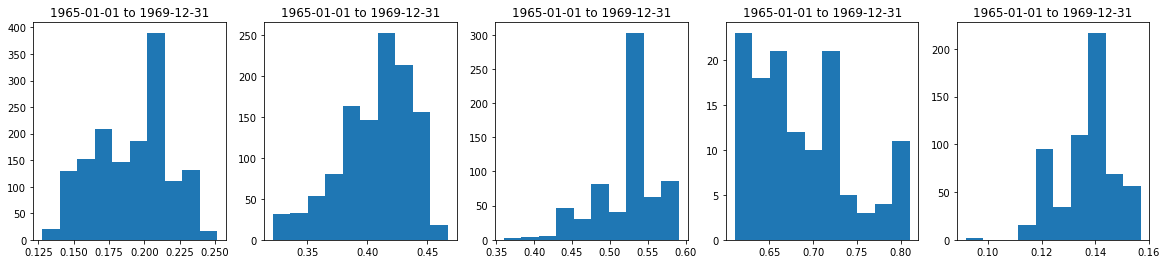

In [ ]:

fig, ax = plt.subplots(1,5, figsize = (20,4))
for index in range(len(years_results_list)):
    year_data = years_results_list[index][1]
    for subplot_index in range(0,5):
    #subplot_index = int(index/3),index%3
        temp = year_data[(year_data.decimalLatitude <= test_regions[subplot_index]['bbox'][3])
                         & (year_data.decimalLatitude >= test_regions[subplot_index]['bbox'][1])] 
        ax[subplot_index].hist(temp.probability)
        ax[subplot_index].title.set_text(#str(years_results_list[index]))
            str(timeslice_list[index][0]) +' to '+str(timeslice_list[index][1]))
    plt.show()

In [148]:
def f(years_results):
    year_data = years_results[1]
    for subplot_index in range(0,5):
    #subplot_index = int(index/3),index%3
        temp = year_data[(year_data.decimalLatitude <= test_regions[subplot_index]['bbox'][3])
                         & (year_data.decimalLatitude >= test_regions[subplot_index]['bbox'][1])] 
        ax[subplot_index].hist(temp.probability)
        ax[subplot_index].title.set_text(#str(years_results_list[index]))
            str(timeslice_list[index][0]) +' to '+str(timeslice_list[index][1]))
    #fig.show()

In [149]:
f(years_results_list[0])

In [140]:
for i in range(0,5):
    print(test_regions[i]['bbox'])

(144.8, -38.5, 145.8, -37.5)
(150.7, -33.5, 151.7, -32.5)
(152.6, -29.0, 153.6, -28.0)
(145.0, -17.7, 146.0, -16.7)
(115.7, -32.5, 116.7, -31.5)


In [138]:
year_data[year_data.decimalLatitude < -37.9]

id  decimalLatitude  decimalLongitude  probability  occurrenceStatus  \
0        0       -37.937500        145.187500     0.000000             False   
2        2       -37.979167        145.354167     0.000000             False   
4        4       -38.479167        145.645833     0.000000             False   
5        5       -37.937500        145.145833     0.050095             False   
9        9       -38.104167        145.145833     0.000000             False   
...    ...              ...               ...          ...               ...   
1471  1471       -38.354167        144.979167     0.000000             False   
1473  1473       -38.187500        145.562500     0.000000             False   
1474  1474       -38.187500        145.562500     0.000000             False   
1475  1475       -38.229167        145.229167     0.001808             False   
1477  1477       -38.229167        145.437500     0.050076             False   

      id_  occurrenceStatus_  
0     NaN                NaN  
2     NaN                NaN  
4     NaN                NaN  
5     NaN                NaN  
9     NaN                NaN  
...   ...                ...  
1471  NaN                NaN  
1473  NaN                NaN  
1474  NaN                NaN  
1475  NaN                NaN  
1477  NaN                NaN  

[542 rows x 7 columns]

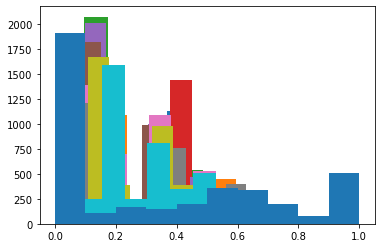

In [112]:
for i in range(len(timeslice_list)):
    plt.hist(years_results_list[i][1].probability)

In [113]:
len(timeslice_list)

11

In [107]:
years_results_list[0][1]

id  decimalLatitude  decimalLongitude  probability  occurrenceStatus  \
0        0       -37.937500        145.187500     0.172069             False   
1        1       -37.770833        144.979167     0.157540             False   
2        2       -37.979167        145.354167     0.184099             False   
3        3       -37.604167        145.020833     0.127028             False   
4        4       -38.479167        145.645833     0.167731             False   
...    ...              ...               ...          ...               ...   
4046  4046       -31.895833        116.145833     0.121096             False   
4047  4047       -32.395833        115.770833     0.110106             False   
4048  4048       -32.145833        115.854167     0.119000             False   
4049  4049       -31.812500        116.229167     0.120663             False   
4050  4050       -31.562500        116.062500     0.116097             False   

      id_  occurrenceStatus_  
0     NaN                NaN  
1     NaN                NaN  
2     NaN                NaN  
3     NaN                NaN  
4     NaN                NaN  
...   ...                ...  
4046  NaN                NaN  
4047  NaN                NaN  
4048  NaN                NaN  
4049  NaN                NaN  
4050  NaN                NaN  

[4051 rows x 7 columns]

In [54]:
for i in range(len(years_results_list)):
    print(years_results_list[i][0],str(np.sum(years_results_list[0][1].occurrenceStatus != years_results_list[i][1].occurrenceStatus)))

1967 0
1972 388
1977 397
1982 167
1987 162
1992 164
1997 162
2002 450
2007 372
2012 389
2017 1388


In [28]:
prop_cycle = plt.rcParams['axes.prop_cycle']
color_list = prop_cycle.by_key()['color']

In [71]:
def plot_frogs_in_time(bboxs, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1,5, figsize = (25,6))
    for index in range(len(bboxs)):
        bbox = bboxs[index]
        extent = [bbox[0],bbox[2],bbox[1],bbox[3]]
        cmap = 'PiYG'

        # Plot real map
        ax[index].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
        cx.add_basemap(ax[index], crs=crs)
        ax[index].set_title('region'+str(index))

        filt = frog_data.occurrenceStatus == 1
        ax[index].scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = color_list[0], marker='o', s=5, alpha=1, label='Target Species'
        )
        non_target = frog_data.occurrenceStatus == 0
        ax[index].scatter(
            frog_data[non_target].decimalLongitude, frog_data[non_target].decimalLatitude, 
            color = color_list[1], marker='o',s=5, alpha=1, label='Off-Target Species'
        )
        ax[index].legend(loc = 'upper left')


    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
#plot_heatmap(resultant_image, all_all_frogs, f"Logistic Regression Model Results - {region_name}")

In [74]:
years_results_list[0][1]

id  decimalLatitude  decimalLongitude  occurrenceStatus
0        0       -37.937500        145.187500                 0
1        1       -37.770833        144.979167                 0
2        2       -37.979167        145.354167                 0
3        3       -37.604167        145.020833                 0
4        4       -38.479167        145.645833                 0
...    ...              ...               ...               ...
4046  4046       -31.895833        116.145833                 0
4047  4047       -32.395833        115.770833                 0
4048  4048       -32.145833        115.854167                 0
4049  4049       -31.812500        116.229167                 0
4050  4050       -31.562500        116.062500                 0

[4051 rows x 4 columns]

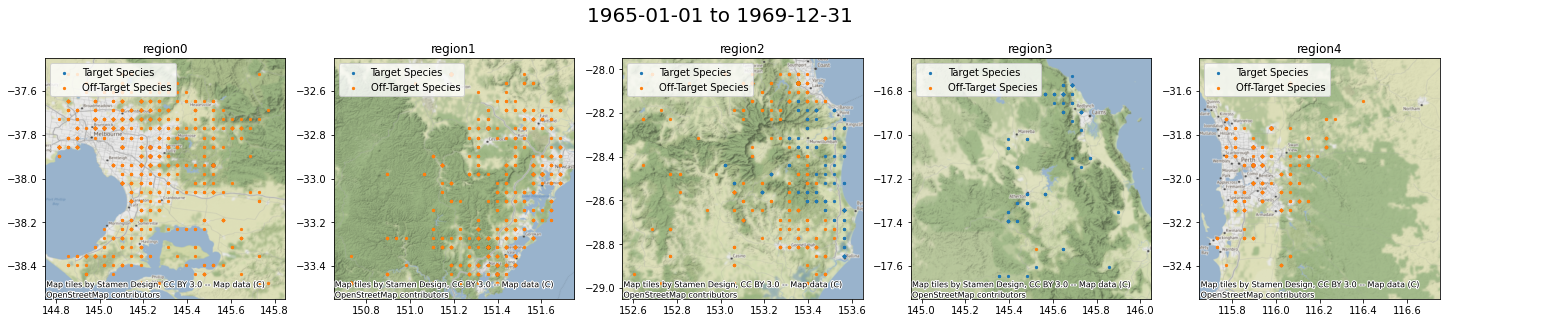

In [72]:
plot_frogs_in_time(test_1_regions, years_results_list[0][1],title=str(timeslice_list[0][0] +' to '+timeslice_list[0][1]))

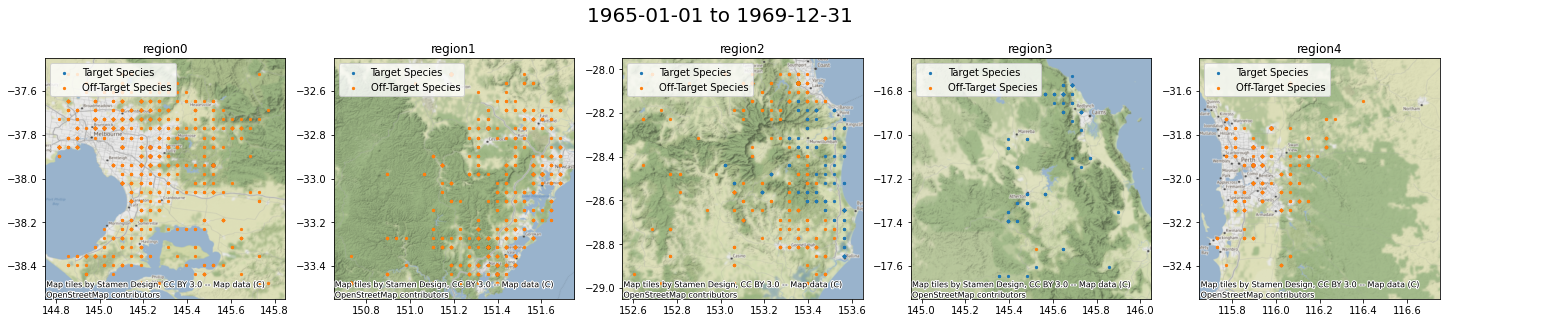

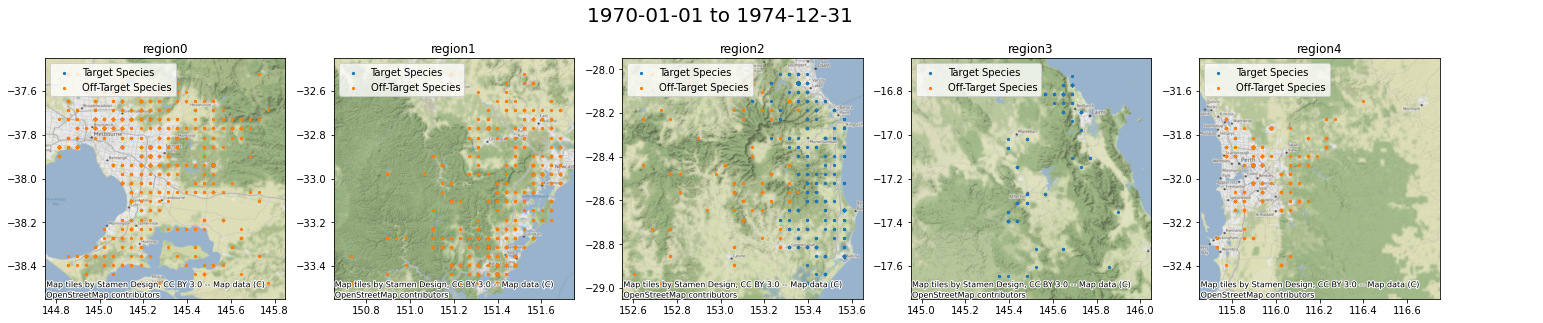

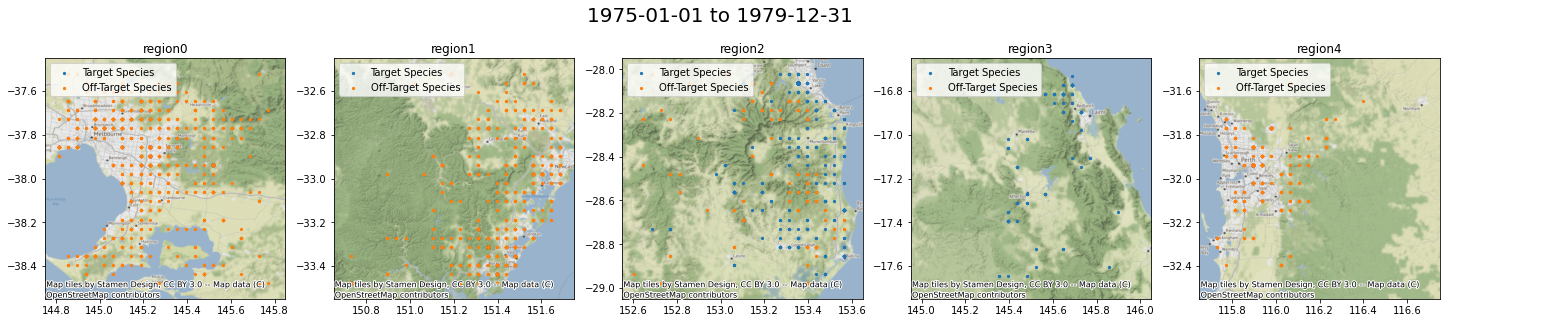

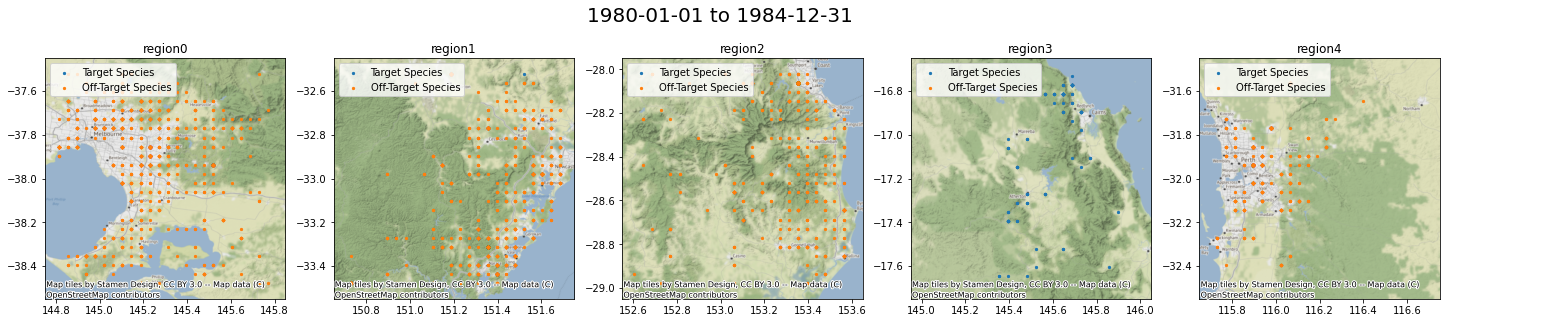

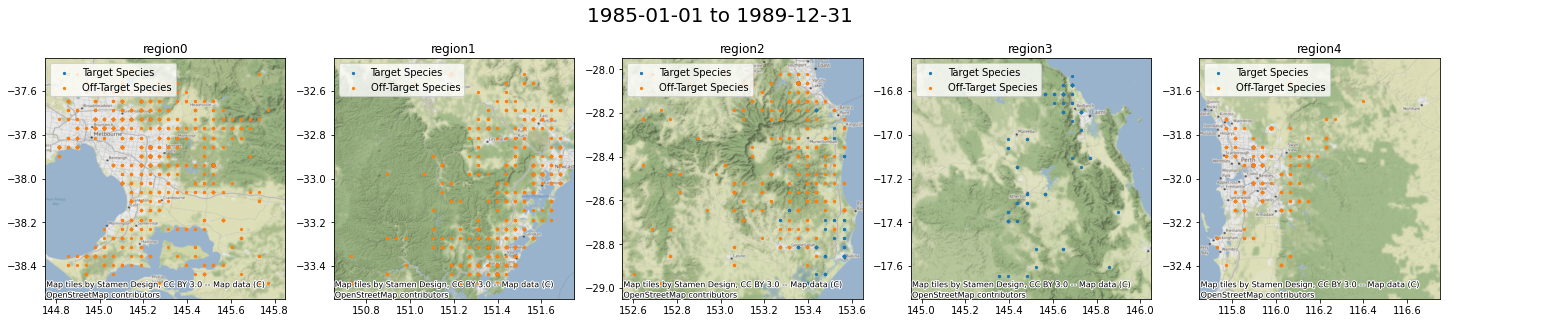

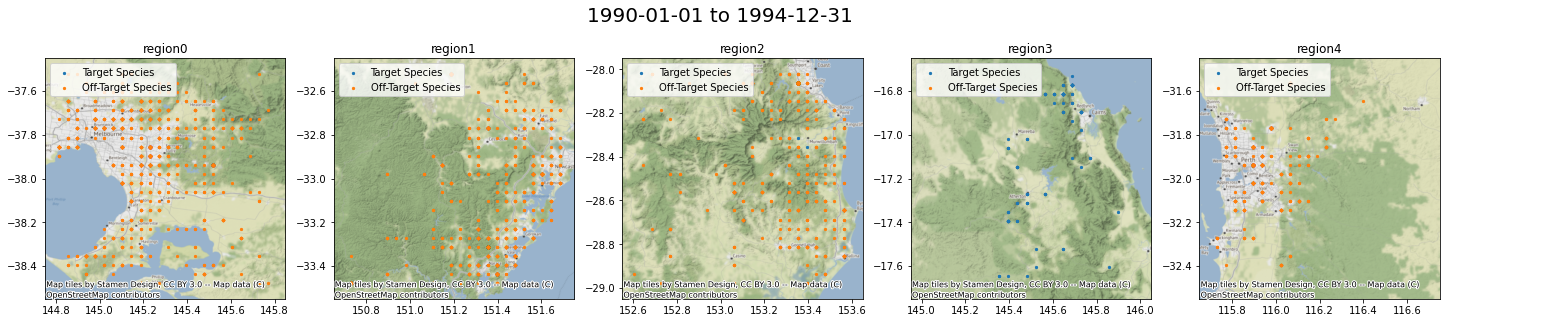

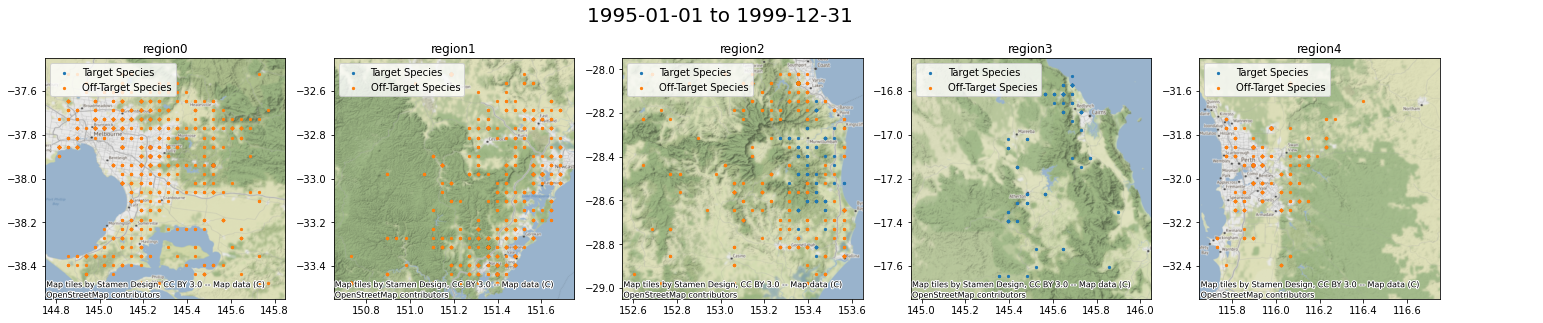

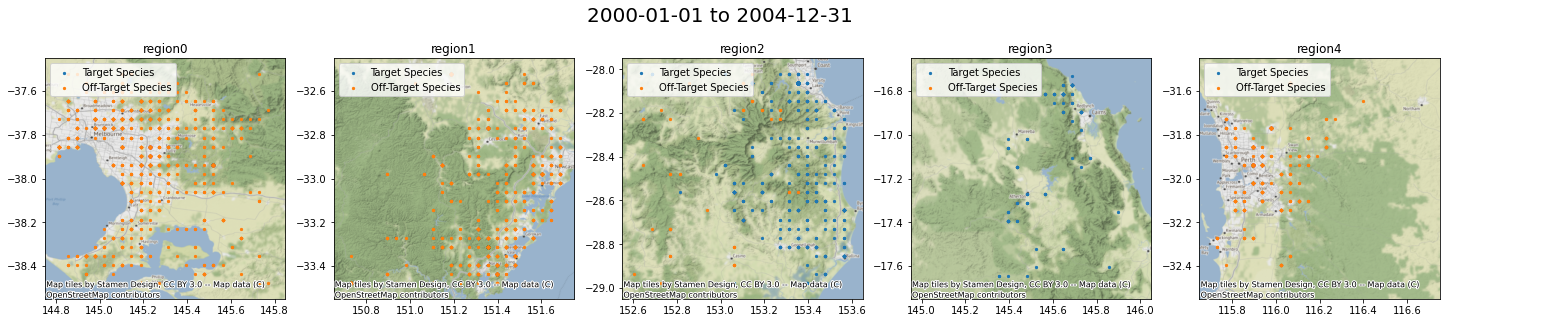

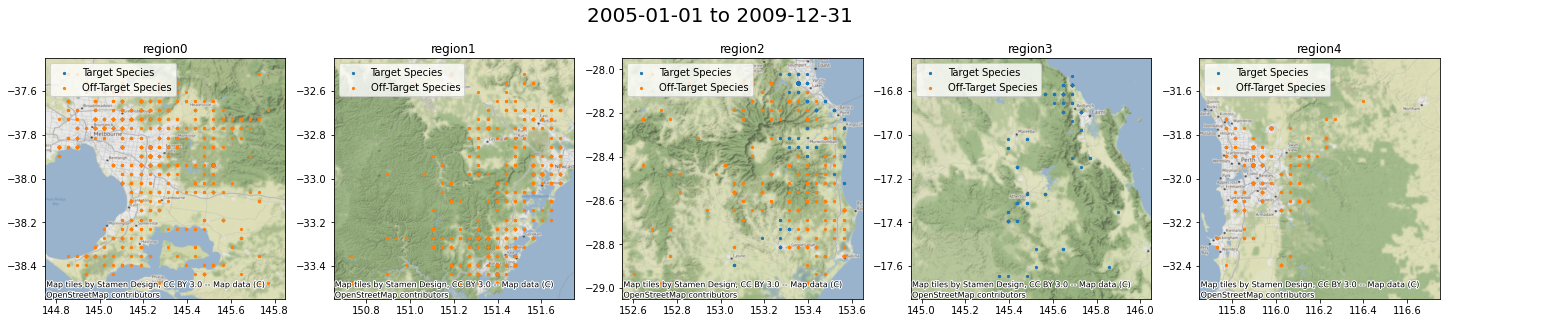

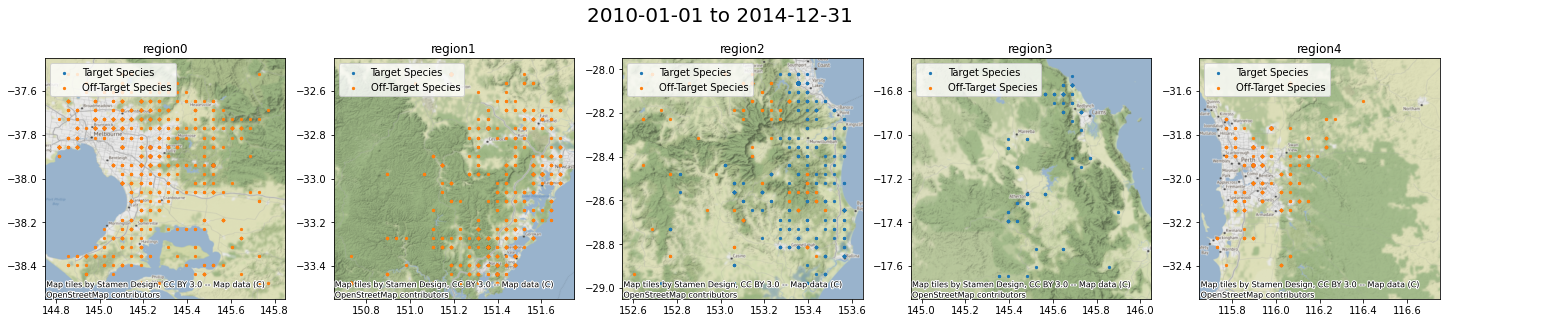

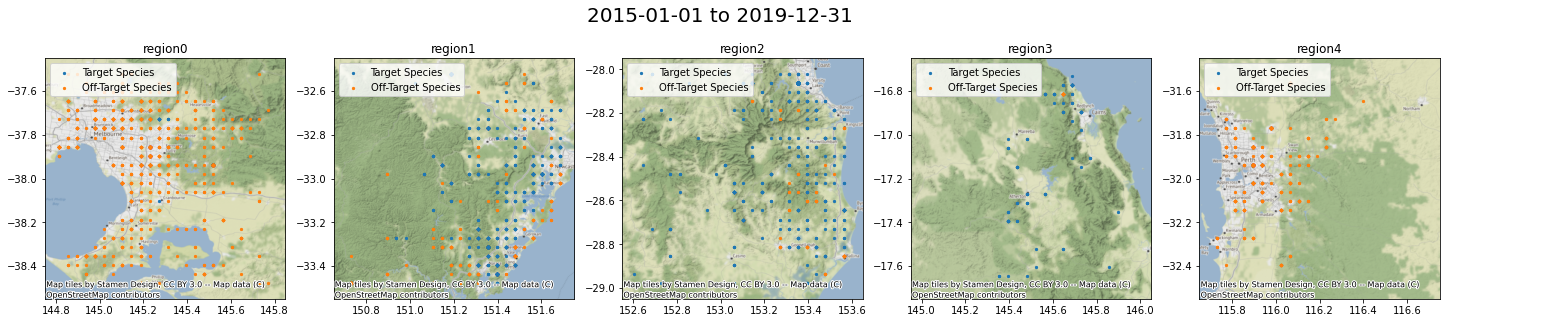

In [73]:
for i in range(len(timeslice_list)):
    plot_frogs_in_time(test_1_regions, years_results_list[i][1],title=str(timeslice_list[i][0] +' to '+timeslice_list[i][1]))

In [ ]:
# plot histogram of ... each of the 5 regions ... hm. 

Loading data


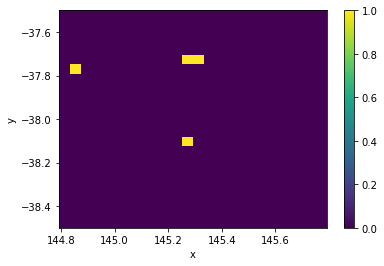

Loading data


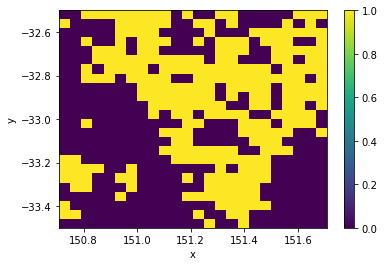

Loading data


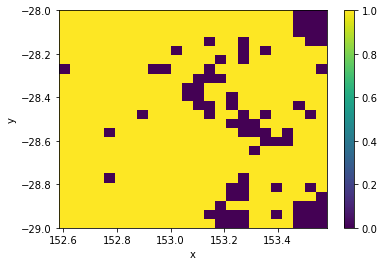

Loading data


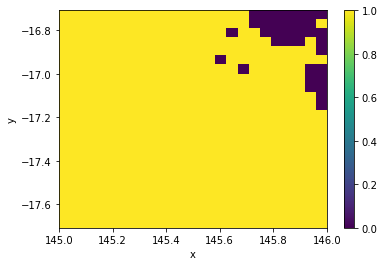

Loading data


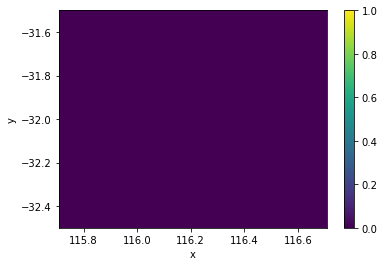

In [5]:
# Obtain predictor data for each region and get predictor image

for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], time_slice=time_slice, assets=assets)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

We can now use these classification regions to assign predictions for each of the coordinates specified in the test file. We do this in a similar way to the `join_frogs` function we defined earlier, except in this case we are joining a prediction to each coordinate.


In [6]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


What we are left with is a submission file with three columns: decimalLatitude, decimalLongitude, and occurrenceStatus. This is the file you will submit to the EY Data Science Challenge platform to receive your score on the leaderboard.

In [20]:
display(submission)

# Save to output folder
#submission.to_csv('challenge_1_submission_best_rerun_tidy.csv', index=None)

id  decimalLatitude  decimalLongitude  occurrenceStatus
0        0       -37.937500        145.187500                 0
1        1       -37.770833        144.979167                 0
2        2       -37.979167        145.354167                 0
3        3       -37.604167        145.020833                 0
4        4       -38.479167        145.645833                 0
...    ...              ...               ...               ...
4046  4046       -31.895833        116.145833                 0
4047  4047       -32.395833        115.770833                 0
4048  4048       -32.145833        115.854167                 0
4049  4049       -31.812500        116.229167                 0
4050  4050       -31.562500        116.062500                 0

[4051 rows x 4 columns]

### Inference runtime: 
Timing the predictions on each region, then will take the mean of that and present it. 

In [7]:
import time

In [8]:
# Obtain predictor data for each region and get predictor image
runtime_list = []
for region in test_regions:
    tic = time.time()
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    toc = time.time()
    inference_runtime = toc - tic
    runtime_list.append(inference_runtime)

In [9]:
runtime_list

[0.05983877182006836,
 0.057845354080200195,
 0.0578460693359375,
 0.0498652458190918,
 0.04192233085632324]

In [10]:
np.mean(runtime_list).round(3)

0.053